In [6]:
# download from https://atlas.fredhutch.org/fredhutch/covid/dataset/su

import os, sys, h5py, anndata
HOMEDIR = os.path.expanduser("~")
PROJDIR = rf"{HOMEDIR}/G-scIB_dev"
sys.path.append(rf"{PROJDIR}/src")

import Data_Handler as dh, Utils_Handler as uh, Vis_Handler as vh
import umap, scipy, numpy as np, pandas as pd, scanpy as sc
sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.settings.verbosity = 3

In [7]:
adata = sc.read_h5ad(dh.DATA_EMB_["COVID"])
obsm_keys = list(adata.obsm)
for embed in obsm_keys:
    print("%12s, %d" % (embed, adata.obsm[embed].shape[1]))
    assert adata.obsm[embed].shape[0] == np.unique(adata.obsm[embed], axis=0).shape[0]

     Harmony, 50
   Scanorama, 100
     X_bbknn, 2
       X_pca, 50
    X_scANVI, 30
      X_scVI, 30
      X_tsne, 2
      X_umap, 2
      scPoli, 10


In [4]:
sc.pp.highly_variable_genes(adata, subset=True, flavor="seurat_v3", n_top_genes=1000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [5]:
adata

AnnData object with n_obs × n_vars = 498822 × 1000
    obs: 'age_standard', 'batch', 'batch_info', 'covid19_standard', 'days_since_hospitalization_estimated_standard', 'days_since_hospitalization_standard', 'days_since_symptom_onset_estimated_standard', 'days_since_symptom_onset_standard', 'disease_severity_standard', 'disease_status_standard', 'id', 'mapping.score', 'nCount_ADT', 'nCount_RNA', 'nCount_SCT', 'nFeature_ADT', 'nFeature_RNA', 'nFeature_SCT', 'orig.ident', 'patient', 'percent.mt', 'predicted.celltype.l1', 'predicted.celltype.l1.score', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'predicted.celltype.l3', 'predicted.celltype.l3.score', 'race_reported_standard', 'sample', 'sample_type_note_standard', 'sample_type_standard', 'sex_standard', 'subbatch', 'tissue_standard', 'n_counts', 'n_genes', '_scvi_batch', '_scvi_labels'
    var: 'feature_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uu

In [6]:
adata.write(rf"{dh.DATA_DIR}/COVID/emb_hvg.h5ad", compression="gzip")

In [2]:
adata = sc.read_h5ad(rf"{dh.DATA_DIR}/COVID/emb_hvg.h5ad")

In [3]:
adata.obsm

AxisArrays with keys: Harmony, Scanorama, X_bbknn, X_pca, X_scANVI, X_scVI, X_tsne, X_umap

In [4]:
del adata.obsm

In [5]:
adata.write(rf"{dh.DATA_DIR}/COVID/emb_hvg.h5ad", compression="gzip")

### Process the raw data

In [3]:
with h5py.File(rf"{dh.DATA_DIR}/COVID/su_2020_processed.HDF5", "r") as f:
    for name in f:
        print(name, f[name])

active.ident <HDF5 group "/active.ident" (2 members)>
assays <HDF5 group "/assays" (8 members)>
cell.names <HDF5 dataset "cell.names": shape (559517,), type "|O">
commands <HDF5 group "/commands" (12 members)>
graphs <HDF5 group "/graphs" (4 members)>
images <HDF5 group "/images" (0 members)>
meta.data <HDF5 group "/meta.data" (44 members)>
misc <HDF5 group "/misc" (2 members)>
neighbors <HDF5 group "/neighbors" (2 members)>
reductions <HDF5 group "/reductions" (7 members)>
tools <HDF5 group "/tools" (0 members)>


In [4]:
f = h5py.File(rf"{dh.DATA_DIR}/COVID/su_2020_processed.HDF5", "r")

In [5]:
data = f['assays']['RNA']['data']['data'][:]
indices = f['assays']['RNA']['data']['indices'][:]
indptr = f['assays']['RNA']['data']['indptr'][:]

# reconstruct the sparse matrix
sparse_matrix1 = scipy.sparse.csc_matrix((data, indices, indptr)).T

In [6]:
data = f['assays']['RNA']['counts']['data'][:]
indices = f['assays']['RNA']['counts']['indices'][:]
indptr = f['assays']['RNA']['counts']['indptr'][:]

# reconstruct the sparse matrix
sparse_matrix2 = scipy.sparse.csc_matrix((data, indices, indptr)).T

In [7]:
uh.compare_sparse_matrices(sparse_matrix1, sparse_matrix2)

True

In [8]:
pd.DataFrame(f['assays']['RNA']['features'], columns=["feature_name"])

,feature_name
0,b'A1BG'
1,b'A1BG-AS1'
2,b'A1CF'
3,b'A2M'
4,b'A2M-AS1'
...,...
33533,b'ZYG11A'
33534,b'ZYG11B'
33535,b'ZYX'
33536,b'ZZEF1'


In [9]:
from h5py import Group, Dataset

In [10]:
for name, value in f["meta.data"].items():
    assert type(value) is Dataset or type(value) is Group

In [11]:
f["meta.data"].keys()

<KeysViewHDF5 ['ADT.weight', 'SCT.weight', '_index', 'adt.snn_res.0.8', 'adtClusterID', 'age_standard', 'batch', 'batch_info', 'covid19_standard', 'days_since_hospitalization_estimated_standard', 'days_since_hospitalization_standard', 'days_since_symptom_onset_estimated_standard', 'days_since_symptom_onset_standard', 'disease_severity_standard', 'disease_status_standard', 'id', 'mapping.score', 'nCount_ADT', 'nCount_RNA', 'nCount_SCT', 'nFeature_ADT', 'nFeature_RNA', 'nFeature_SCT', 'orig.ident', 'patient', 'percent.mt', 'predicted.celltype.l1', 'predicted.celltype.l1.score', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'predicted.celltype.l3', 'predicted.celltype.l3.score', 'race_reported_standard', 'rna.snn_res.0.8', 'rnaClusterID', 'sample', 'sample_type_note_standard', 'sample_type_standard', 'seurat_clusters', 'sex_standard', 'subbatch', 'tissue_standard', 'wsnnClusterID', 'wsnn_res.0.8']>

In [12]:
meta_data_df = pd.DataFrame()

for name, value in f["meta.data"].items():
    if type(value) is Dataset:
        meta_data_df[name] = value

for col in meta_data_df.columns:
    meta_data_df[col] = meta_data_df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

meta_data_df

,ADT.weight,SCT.weight,_index,age_standard,batch,batch_info,covid19_standard,days_since_hospitalization_estimated_standard,days_since_hospitalization_standard,days_since_symptom_onset_estimated_standard,...,predicted.celltype.l2.score,predicted.celltype.l3,predicted.celltype.l3.score,race_reported_standard,sample,sample_type_note_standard,sample_type_standard,sex_standard,subbatch,tissue_standard
0,2.454256e-01,7.545744e-01,AAACCTGAGATGTAAC-1-1:Mix:Mix_donor1,-2147483648,1,1:Mix:Mix_donor1,0,2,-2147483648,2,...,0.621235,CD8 TCM_1,0.471679,,Mix_donor1,,Peripheral Blood Mononuclear Cells,female,Mix,Blood
1,8.749786e-09,1.000000e+00,AAACCTGAGGGCTTGA-1-1:Mix:Mix_donor1,-2147483648,1,1:Mix:Mix_donor1,0,2,-2147483648,2,...,0.683217,CD4 TEM_1,0.559214,,Mix_donor1,,Peripheral Blood Mononuclear Cells,female,Mix,Blood
2,1.276358e-86,1.000000e+00,AAACCTGCATGGGACA-1-1:Mix:Mix_donor1,-2147483648,1,1:Mix:Mix_donor1,0,2,-2147483648,2,...,0.933856,CD8 Naive,0.933856,,Mix_donor1,,Peripheral Blood Mononuclear Cells,female,Mix,Blood
3,7.326273e-02,9.267373e-01,AAACCTGGTAGAGTGC-1-1:Mix:Mix_donor1,-2147483648,1,1:Mix:Mix_donor1,0,2,-2147483648,2,...,1.000000,CD16 Mono,1.000000,,Mix_donor1,,Peripheral Blood Mononuclear Cells,female,Mix,Blood
4,4.087571e-82,1.000000e+00,AAACCTGTCCCTTGTG-1-1:Mix:Mix_donor1,-2147483648,1,1:Mix:Mix_donor1,0,2,-2147483648,2,...,1.000000,CD14 Mono,1.000000,,Mix_donor1,,Peripheral Blood Mononuclear Cells,female,Mix,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559512,2.311666e-03,9.976883e-01,TTTGTCAAGCTGATAA-1-10:J2:111-1,28,10,10:J2:111-1,0,1,0,1,...,1.000000,NK_1,0.699322,Native Hawaiian or Other Pacific Islander,111-1,,Peripheral Blood Mononuclear Cells,male,J2,Blood
559513,1.750647e-86,1.000000e+00,TTTGTCAAGGAGTACC-1-10:J2:111-1,28,10,10:J2:111-1,0,1,0,1,...,0.612960,CD4 CTL,0.387040,Native Hawaiian or Other Pacific Islander,111-1,,Peripheral Blood Mononuclear Cells,male,J2,Blood
559514,8.738308e-01,1.261692e-01,TTTGTCACAACAACCT-1-10:J2:111-1,28,10,10:J2:111-1,0,1,0,1,...,0.994356,B memory kappa,0.610674,Native Hawaiian or Other Pacific Islander,111-1,,Peripheral Blood Mononuclear Cells,male,J2,Blood
559515,9.999995e-01,5.249865e-07,TTTGTCACACAACGCC-1-10:J2:111-1,28,10,10:J2:111-1,0,1,0,1,...,1.000000,CD14 Mono,1.000000,Native Hawaiian or Other Pacific Islander,111-1,,Peripheral Blood Mononuclear Cells,male,J2,Blood


In [13]:
meta_data_df

,ADT.weight,SCT.weight,_index,age_standard,batch,batch_info,covid19_standard,days_since_hospitalization_estimated_standard,days_since_hospitalization_standard,days_since_symptom_onset_estimated_standard,...,predicted.celltype.l2.score,predicted.celltype.l3,predicted.celltype.l3.score,race_reported_standard,sample,sample_type_note_standard,sample_type_standard,sex_standard,subbatch,tissue_standard
0,2.454256e-01,7.545744e-01,AAACCTGAGATGTAAC-1-1:Mix:Mix_donor1,-2147483648,1,1:Mix:Mix_donor1,0,2,-2147483648,2,...,0.621235,CD8 TCM_1,0.471679,,Mix_donor1,,Peripheral Blood Mononuclear Cells,female,Mix,Blood
1,8.749786e-09,1.000000e+00,AAACCTGAGGGCTTGA-1-1:Mix:Mix_donor1,-2147483648,1,1:Mix:Mix_donor1,0,2,-2147483648,2,...,0.683217,CD4 TEM_1,0.559214,,Mix_donor1,,Peripheral Blood Mononuclear Cells,female,Mix,Blood
2,1.276358e-86,1.000000e+00,AAACCTGCATGGGACA-1-1:Mix:Mix_donor1,-2147483648,1,1:Mix:Mix_donor1,0,2,-2147483648,2,...,0.933856,CD8 Naive,0.933856,,Mix_donor1,,Peripheral Blood Mononuclear Cells,female,Mix,Blood
3,7.326273e-02,9.267373e-01,AAACCTGGTAGAGTGC-1-1:Mix:Mix_donor1,-2147483648,1,1:Mix:Mix_donor1,0,2,-2147483648,2,...,1.000000,CD16 Mono,1.000000,,Mix_donor1,,Peripheral Blood Mononuclear Cells,female,Mix,Blood
4,4.087571e-82,1.000000e+00,AAACCTGTCCCTTGTG-1-1:Mix:Mix_donor1,-2147483648,1,1:Mix:Mix_donor1,0,2,-2147483648,2,...,1.000000,CD14 Mono,1.000000,,Mix_donor1,,Peripheral Blood Mononuclear Cells,female,Mix,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559512,2.311666e-03,9.976883e-01,TTTGTCAAGCTGATAA-1-10:J2:111-1,28,10,10:J2:111-1,0,1,0,1,...,1.000000,NK_1,0.699322,Native Hawaiian or Other Pacific Islander,111-1,,Peripheral Blood Mononuclear Cells,male,J2,Blood
559513,1.750647e-86,1.000000e+00,TTTGTCAAGGAGTACC-1-10:J2:111-1,28,10,10:J2:111-1,0,1,0,1,...,0.612960,CD4 CTL,0.387040,Native Hawaiian or Other Pacific Islander,111-1,,Peripheral Blood Mononuclear Cells,male,J2,Blood
559514,8.738308e-01,1.261692e-01,TTTGTCACAACAACCT-1-10:J2:111-1,28,10,10:J2:111-1,0,1,0,1,...,0.994356,B memory kappa,0.610674,Native Hawaiian or Other Pacific Islander,111-1,,Peripheral Blood Mononuclear Cells,male,J2,Blood
559515,9.999995e-01,5.249865e-07,TTTGTCACACAACGCC-1-10:J2:111-1,28,10,10:J2:111-1,0,1,0,1,...,1.000000,CD14 Mono,1.000000,Native Hawaiian or Other Pacific Islander,111-1,,Peripheral Blood Mononuclear Cells,male,J2,Blood


In [14]:
for _col in meta_data_df.columns:
    # if "predicted" in _col:
    #     del meta_data_df[_col]
    if ".weight" in _col:
        del meta_data_df[_col]
    if "_index" in _col:
        del meta_data_df[_col]

In [15]:
meta_data_df.columns

Index(['age_standard', 'batch', 'batch_info', 'covid19_standard',
       'days_since_hospitalization_estimated_standard',
       'days_since_hospitalization_standard',
       'days_since_symptom_onset_estimated_standard',
       'days_since_symptom_onset_standard', 'disease_severity_standard',
       'disease_status_standard', 'id', 'mapping.score', 'nCount_ADT',
       'nCount_RNA', 'nCount_SCT', 'nFeature_ADT', 'nFeature_RNA',
       'nFeature_SCT', 'orig.ident', 'patient', 'percent.mt',
       'predicted.celltype.l1', 'predicted.celltype.l1.score',
       'predicted.celltype.l2', 'predicted.celltype.l2.score',
       'predicted.celltype.l3', 'predicted.celltype.l3.score',
       'race_reported_standard', 'sample', 'sample_type_note_standard',
       'sample_type_standard', 'sex_standard', 'subbatch', 'tissue_standard'],
      dtype='object')

In [16]:
meta_data_df['predicted.celltype.l3']

0              CD8 TCM_1
1              CD4 TEM_1
2              CD8 Naive
3              CD16 Mono
4              CD14 Mono
               ...      
559512              NK_1
559513           CD4 CTL
559514    B memory kappa
559515         CD14 Mono
559516         CD14 Mono
Name: predicted.celltype.l3, Length: 559517, dtype: object

In [17]:
adata = anndata.AnnData(X=sparse_matrix1)
adata.obs = meta_data_df
adata.var = pd.DataFrame(f['assays']['RNA']['features'], columns=["feature_name"])[:-1]

adata.write(rf"{dh.DATA_DIR}/COVID/local.h5ad", compression="gzip")

In [18]:
adata = sc.read_h5ad(dh.DATA_RAW_["COVID"])

In [19]:
adata

AnnData object with n_obs × n_vars = 559517 × 33537
    obs: 'age_standard', 'batch', 'batch_info', 'covid19_standard', 'days_since_hospitalization_estimated_standard', 'days_since_hospitalization_standard', 'days_since_symptom_onset_estimated_standard', 'days_since_symptom_onset_standard', 'disease_severity_standard', 'disease_status_standard', 'id', 'mapping.score', 'nCount_ADT', 'nCount_RNA', 'nCount_SCT', 'nFeature_ADT', 'nFeature_RNA', 'nFeature_SCT', 'orig.ident', 'patient', 'percent.mt', 'predicted.celltype.l1', 'predicted.celltype.l1.score', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'predicted.celltype.l3', 'predicted.celltype.l3.score', 'race_reported_standard', 'sample', 'sample_type_note_standard', 'sample_type_standard', 'sex_standard', 'subbatch', 'tissue_standard'
    var: 'feature_name'

In [20]:
uh.preprocess(adata)

filtered out 55530 cells that have less than 1000 counts
filtered out 5165 cells that have less than 500 genes expressed
filtered out 9672 genes that are detected in less than 5 cells
23865 genes x 498822 cells after quality control.
normalizing by total count per cell
    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


AnnData object with n_obs × n_vars = 498822 × 23865
    obs: 'age_standard', 'batch', 'batch_info', 'covid19_standard', 'days_since_hospitalization_estimated_standard', 'days_since_hospitalization_standard', 'days_since_symptom_onset_estimated_standard', 'days_since_symptom_onset_standard', 'disease_severity_standard', 'disease_status_standard', 'id', 'mapping.score', 'nCount_ADT', 'nCount_RNA', 'nCount_SCT', 'nFeature_ADT', 'nFeature_RNA', 'nFeature_SCT', 'orig.ident', 'patient', 'percent.mt', 'predicted.celltype.l1', 'predicted.celltype.l1.score', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'predicted.celltype.l3', 'predicted.celltype.l3.score', 'race_reported_standard', 'sample', 'sample_type_note_standard', 'sample_type_standard', 'sex_standard', 'subbatch', 'tissue_standard', 'n_counts', 'n_genes'
    var: 'feature_name', 'n_cells'
    uns: 'log1p'

In [21]:
adata

AnnData object with n_obs × n_vars = 498822 × 23865
    obs: 'age_standard', 'batch', 'batch_info', 'covid19_standard', 'days_since_hospitalization_estimated_standard', 'days_since_hospitalization_standard', 'days_since_symptom_onset_estimated_standard', 'days_since_symptom_onset_standard', 'disease_severity_standard', 'disease_status_standard', 'id', 'mapping.score', 'nCount_ADT', 'nCount_RNA', 'nCount_SCT', 'nFeature_ADT', 'nFeature_RNA', 'nFeature_SCT', 'orig.ident', 'patient', 'percent.mt', 'predicted.celltype.l1', 'predicted.celltype.l1.score', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'predicted.celltype.l3', 'predicted.celltype.l3.score', 'race_reported_standard', 'sample', 'sample_type_note_standard', 'sample_type_standard', 'sex_standard', 'subbatch', 'tissue_standard', 'n_counts', 'n_genes'
    var: 'feature_name', 'n_cells'
    uns: 'log1p'

In [22]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:04:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:06:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:10:22)


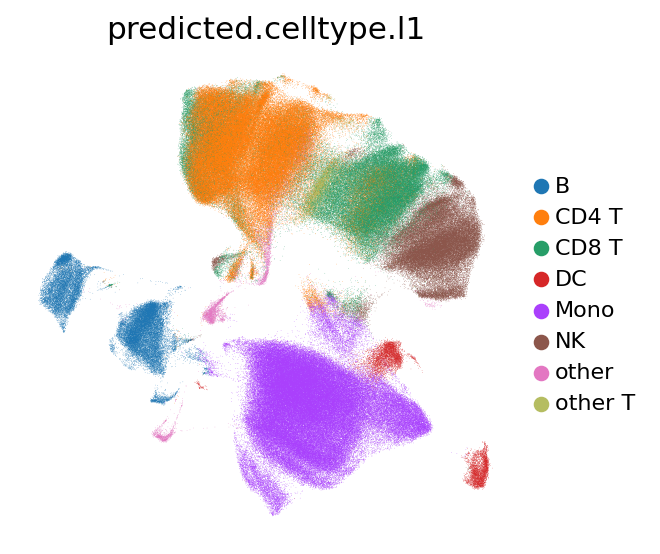

In [23]:
sc.pl.embedding(
    adata,
    basis="X_umap",
    color=["predicted.celltype.l1"],
    **vh.cfg
)

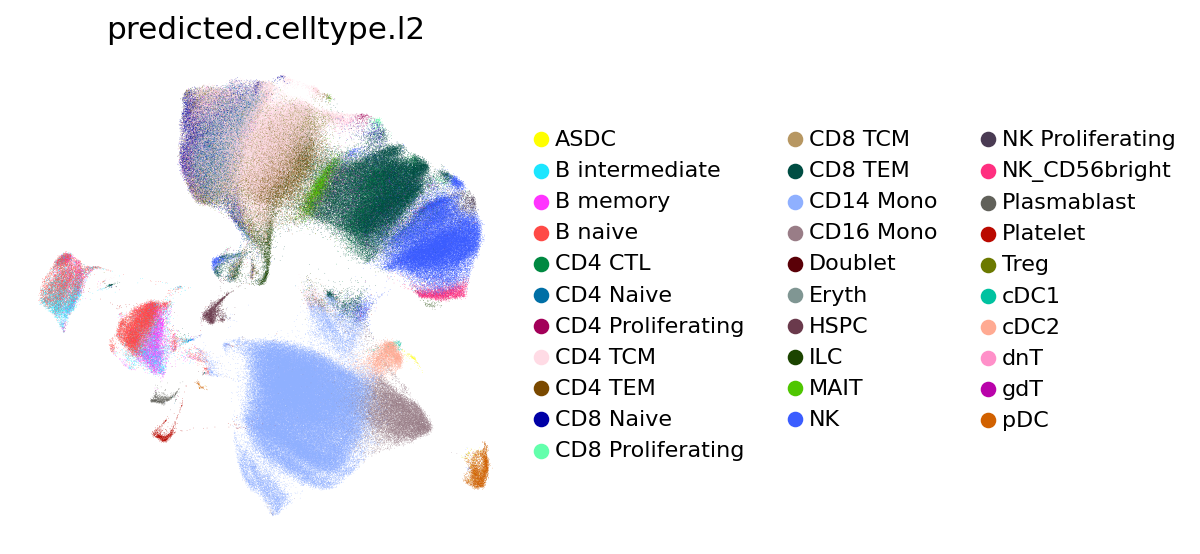

In [24]:
sc.pl.embedding(
    adata,
    basis="X_umap",
    color=["predicted.celltype.l2"],
    **vh.cfg
)

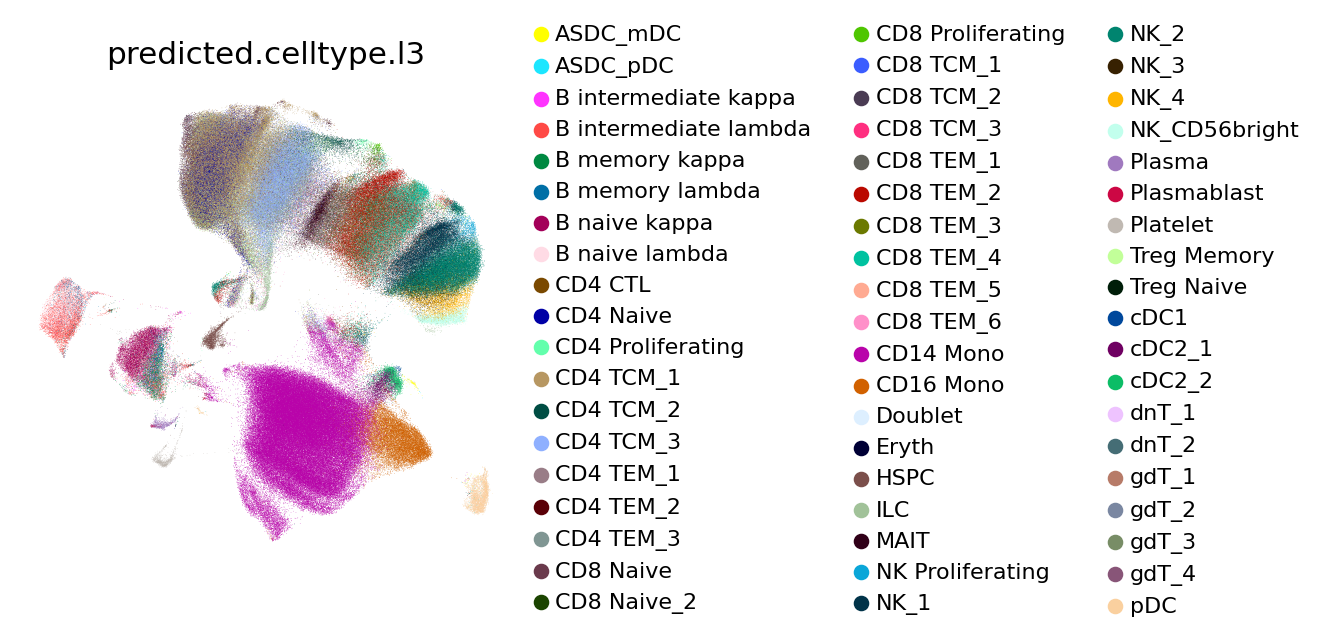

In [25]:
sc.pl.embedding(
    adata,
    basis="X_umap",
    color=["predicted.celltype.l3"],
    **vh.cfg
)

In [26]:
adata.obs["sample"].unique()

['Mix_donor1', 'CL2', '1-1', '1-2', '2-1', ..., '86-1', '116-1', '104-1', '112-1', '119-1']
Length: 270
Categories (270, object): ['1-1', '1-2', '2-1', '2-2', ..., 'BP05191345', 'BP08191115', 'CL2', 'Mix_donor1']

In [27]:
adata.obs["batch"].unique()

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Categories (10, object): ['1', '2', '3', '4', ..., '7', '8', '9', '10']

In [28]:
adata.write(rf"{dh.DATA_DIR}/COVID/emb.h5ad", compression="gzip")

### Save Metadata

In [2]:
os.makedirs(rf"{dh.META_DIR}/COVID/", exist_ok=True)

In [3]:
adata = sc.read_h5ad(rf"{dh.DATA_DIR}/COVID/emb.h5ad")

In [4]:
import json
CELL2CAT = dict()
for idx, batch in enumerate(adata.obs["predicted.celltype.l2"].unique()):
    CELL2CAT[batch] = idx
_file = open(rf"{dh.META_DIR}/COVID/cell2cat.json", "w")
_file.write(json.dumps(CELL2CAT))
_file.close()

BATCH2CAT = dict()
for idx, batch in enumerate(adata.obs["batch"].unique()):
    BATCH2CAT[batch] = idx
_file = open(rf"{dh.META_DIR}/COVID/batch2cat.json", "w")
_file.write(json.dumps(BATCH2CAT))
_file.close()